Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping


Step 2: Load and Explore Data

📊 Dataset loaded!
Shape: (29964, 5)

First 5 rows:
            a           b  opcode  faulty_result  fault_type
0   303379748  3230228097       2          70656           0
1  2223298057  2985317987       0      913648748           0
2   112818957  1189058957       2      110696719           1
3  2999092325  2302104082       2     3238658048           1
4    15983361   114806029       4      103034380           0

🔍 Fault Type Distribution:
  No Fault: 11993 samples
  Bitflip: 11964 samples
  Opcode Fault: 6007 samples


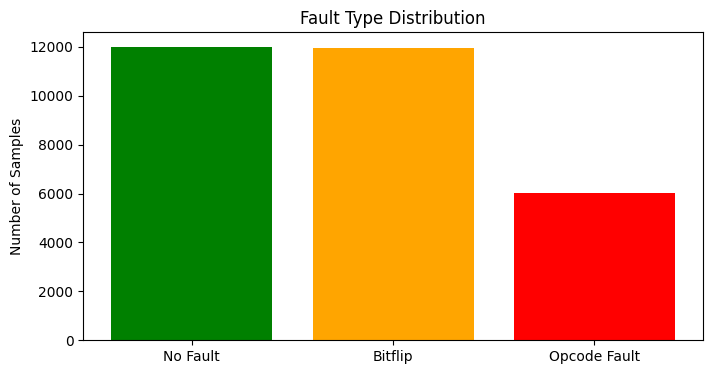

In [2]:
# Load your dataset
df = pd.read_csv("enhanced_dataset_dl.csv")
print("📊 Dataset loaded!")
print(f"Shape: {df.shape}")

# Show first few rows
print("\nFirst 5 rows:")
print(df.head())

# Check fault distribution
print("\n🔍 Fault Type Distribution:")
fault_counts = df['fault_type'].value_counts().sort_index()
fault_names = {0: "No Fault", 1: "Bitflip", 2: "Opcode Fault"}

for fault_id, count in fault_counts.items():
    print(f"  {fault_names[fault_id]}: {count} samples")

# Visualize the distribution
plt.figure(figsize=(8, 4))
plt.bar(fault_names.values(), fault_counts.values, color=['green', 'orange', 'red'])
plt.title('Fault Type Distribution')
plt.ylabel('Number of Samples')
plt.show()

Step 3: Prepare Features

In [3]:
print("🛠️ Preparing features...")

def calculate_correct_result(a, b, opcode):
    """Calculate what the correct ALU result should be"""
    if opcode == 0: return (a + b) & 0xFFFFFFFF  # ADD
    elif opcode == 1: return (a - b) & 0xFFFFFFFF  # SUB
    elif opcode == 2: return a & b  # AND
    elif opcode == 3: return a | b  # OR
    elif opcode == 4: return a ^ b  # XOR
    else: return 0

# Calculate correct results
df['correct_result'] = df.apply(
    lambda row: calculate_correct_result(row['a'], row['b'], row['opcode']), 
    axis=1
)

# Calculate error bits (XOR between faulty and correct result)
df['error_bits'] = df['faulty_result'] ^ df['correct_result']

print("✅ Features prepared!")
print(f"New columns: {df.columns.tolist()}")

🛠️ Preparing features...
✅ Features prepared!
New columns: ['a', 'b', 'opcode', 'faulty_result', 'fault_type', 'correct_result', 'error_bits']


Step 4: Create CNN Input Features

In [4]:
print("🎯 Creating CNN input features...")

# Convert error bits to 32-bit binary sequences
def error_to_binary(error_int):
    """Convert error integer to 32-bit binary sequence"""
    binary_str = format(error_int, '032b')  # 32-bit binary string
    return [int(bit) for bit in binary_str]

# Create feature matrix
X_bits = np.array([error_to_binary(x) for x in df['error_bits']])
y = df['fault_type'].values

print(f"Feature shape: {X_bits.shape}")
print(f"Target shape: {y.shape}")

🎯 Creating CNN input features...
Feature shape: (29964, 32)
Target shape: (29964,)


Step 5: Split Data and Prepare for CNN

In [5]:
print("📂 Splitting data...")

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_bits, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Keep same distribution in both sets
)

# Reshape for CNN (samples, sequence_length, features)
X_train_cnn = X_train.reshape(X_train.shape[0], 32, 1)
X_test_cnn = X_test.reshape(X_test.shape[0], 32, 1)

print(f"Training data: {X_train_cnn.shape}")
print(f"Testing data: {X_test_cnn.shape}")
print(f"Training labels: {y_train.shape}")

📂 Splitting data...
Training data: (23971, 32, 1)
Testing data: (5993, 32, 1)
Training labels: (23971,)


Step 6: Build Simple CNN Model

In [6]:
print("🧠 Building CNN model...")

model = Sequential([
    # First convolutional layer
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(32, 1)),
    MaxPooling1D(pool_size=2),
    
    # Second convolutional layer  
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    # Flatten and dense layers
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    
    # Output layer (3 classes: No Fault, Bitflip, Opcode Fault)
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model built successfully!")
model.summary()

🧠 Building CNN model...
✅ Model built successfully!


c:\Users\mithu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 13, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,171 (121.76 KB)

 Trainable params: 31,171 (121.76 KB)

 Non-trainable params: 0 (0.00 B)

Step 7: Train the Model

In [7]:
print("🚀 Training model...")

# Stop training if validation loss doesn't improve
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("✅ Training completed!")

🚀 Training model...
Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9524 - loss: 0.1595 - val_accuracy: 0.9831 - val_loss: 0.0735
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9806 - loss: 0.0919 - val_accuracy: 0.9863 - val_loss: 0.0702
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9808 - loss: 0.0870 - val_accuracy: 0.9865 - val_loss: 0.0671
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9807 - loss: 0.0873 - val_accuracy: 0.9820 - val_loss: 0.0793
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9816 - loss: 0.0849 - val_accuracy: 0.9865 - val_loss: 0.0643
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9818 - loss: 0.0834 - val_accuracy: 0.9853 - val_loss: 0.0665
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9821 - loss: 0.0810 - val_accuracy: 0.9867 - val_loss: 0.0635
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9823 - loss: 0.080

Step 8: Evaluate Model Performance

📈 Evaluating model...
🎯 Test Accuracy: 98.73%


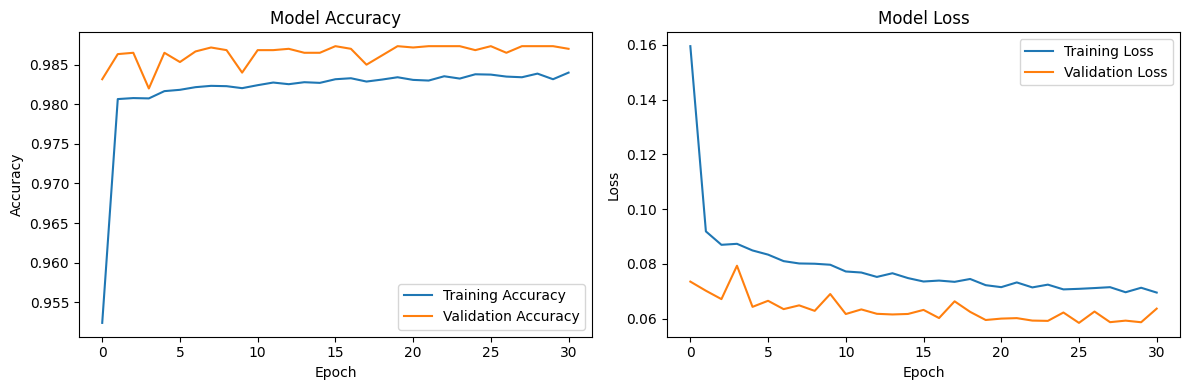

In [8]:
print("📈 Evaluating model...")

# Test accuracy
test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"🎯 Test Accuracy: {test_acc*100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Step 9: Detailed Performance Analysis

🔍 Detailed performance analysis...
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


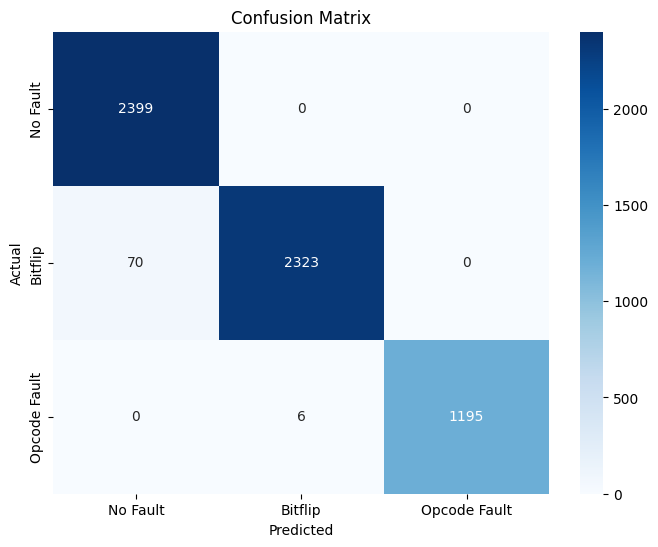


📊 Classification Report:
              precision    recall  f1-score   support

    No Fault       0.97      1.00      0.99      2399
     Bitflip       1.00      0.97      0.98      2393
Opcode Fault       1.00      1.00      1.00      1201

    accuracy                           0.99      5993
   macro avg       0.99      0.99      0.99      5993
weighted avg       0.99      0.99      0.99      5993



In [12]:
print("🔍 Detailed performance analysis...")

# Make predictions
y_pred = np.argmax(model.predict(X_test_cnn), axis=1)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fault', 'Bitflip', 'Opcode Fault'],
            yticklabels=['No Fault', 'Bitflip', 'Opcode Fault'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['No Fault', 'Bitflip', 'Opcode Fault']))

Step 10: Test with Custom Examples

In [10]:
print("🧪 Testing with custom examples...")

def predict_fault(a, b, opcode, faulty_result):
    """Predict fault type for custom inputs"""
    # Calculate correct result
    correct = calculate_correct_result(a, b, opcode)
    
    # Calculate error bits
    error_bits = faulty_result ^ correct
    
    # Convert to binary sequence
    error_sequence = error_to_binary(error_bits)
    X_input = np.array(error_sequence).reshape(1, 32, 1)
    
    # Make prediction
    prediction = model.predict(X_input, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class] * 100
    
    return fault_names[predicted_class], confidence

# Test cases
test_cases = [
    (100, 200, 0, 300),    # No fault expected
    (100, 200, 0, 1324),   # Bitflip expected  
    (500, 150, 1, 503)     # Opcode fault expected
]

print("\nCustom Test Results:")
for i, (a, b, opcode, faulty) in enumerate(test_cases):
    fault_type, confidence = predict_fault(a, b, opcode, faulty)
    print(f"Test {i+1}: A={a}, B={b}, Opcode={opcode}, Faulty={faulty}")
    print(f"  → Predicted: {fault_type} ({confidence:.1f}% confidence)")
    print()

🧪 Testing with custom examples...

Custom Test Results:
Test 1: A=100, B=200, Opcode=0, Faulty=300
  → Predicted: No Fault (96.3% confidence)

Test 2: A=100, B=200, Opcode=0, Faulty=1324
  → Predicted: Bitflip (100.0% confidence)

Test 3: A=500, B=150, Opcode=1, Faulty=503
  → Predicted: Bitflip (100.0% confidence)



Step 11: Save the Model

In [11]:
print("💾 Saving model...")

# Save the trained model
model.save('alu_fault_cnn_model.h5')

print("✅ Model saved as 'alu_fault_cnn_model.h5'")
print("🎉 All done! Your ALU fault detection model is ready!")

💾 Saving model...
✅ Model saved as 'alu_fault_cnn_model.h5'
🎉 All done! Your ALU fault detection model is ready!


testing

In [13]:
# 🧪 SIMPLE MODEL TESTING
print("🧪 TESTING YOUR TRAINED MODEL")
print("=" * 40)

# Test cases that cover all scenarios
test_cases = [
    # Format: (A, B, Opcode, Faulty_Result, Description)
    
    # No Fault cases (correct results)
    (100, 200, 0, 300, "ADD: Correct result"),
    (50, 30, 1, 20, "SUB: Correct result"),
    (15, 10, 2, 10, "AND: Correct result"),
    (5, 3, 3, 7, "OR: Correct result"),
    (12, 6, 4, 10, "XOR: Correct result"),
    
    # Bitflip cases (single bit errors)
    (100, 200, 0, 301, "Bitflip: LSB flipped (300 → 301)"),
    (100, 200, 0, 1324, "Bitflip: Bit 10 flipped"),
    (255, 1, 0, 260, "Bitflip: Multiple bits flipped"),
    
    # Opcode Fault cases (wrong operation)
    (100, 200, 0, 100 & 200, "Opcode Fault: ADD but AND result"),
    (100, 200, 1, 100 | 200, "Opcode Fault: SUB but OR result"),
    (15, 10, 2, 15 + 10, "Opcode Fault: AND but ADD result"),
]

print(f"Testing {len(test_cases)} different scenarios...\n")

correct_predictions = 0

for i, (a, b, opcode, faulty, description) in enumerate(test_cases, 1):
    # Get model prediction
    fault_type, confidence = predict_fault(a, b, opcode, faulty)
    
    # For display purposes, let's see what the correct result should be
    correct = calculate_correct_result(a, b, opcode)
    error_bits = faulty ^ correct
    
    print(f"Test {i}: {description}")
    print(f"   Input: A={a}, B={b}, Opcode={opcode}")
    print(f"   Faulty Result: {faulty} | Correct Result: {correct}")
    print(f"   Error Bits: {error_bits:032b}")
    print(f"   🎯 Prediction: {fault_type} ({confidence:.1f}% confidence)")
    print()

print("✅ Testing completed!")

🧪 TESTING YOUR TRAINED MODEL
Testing 11 different scenarios...

Test 1: ADD: Correct result
   Input: A=100, B=200, Opcode=0
   Faulty Result: 300 | Correct Result: 300
   Error Bits: 00000000000000000000000000000000
   🎯 Prediction: No Fault (96.3% confidence)

Test 2: SUB: Correct result
   Input: A=50, B=30, Opcode=1
   Faulty Result: 20 | Correct Result: 20
   Error Bits: 00000000000000000000000000000000
   🎯 Prediction: No Fault (96.3% confidence)

Test 3: AND: Correct result
   Input: A=15, B=10, Opcode=2
   Faulty Result: 10 | Correct Result: 10
   Error Bits: 00000000000000000000000000000000
   🎯 Prediction: No Fault (96.3% confidence)

Test 4: OR: Correct result
   Input: A=5, B=3, Opcode=3
   Faulty Result: 7 | Correct Result: 7
   Error Bits: 00000000000000000000000000000000
   🎯 Prediction: No Fault (96.3% confidence)

Test 5: XOR: Correct result
   Input: A=12, B=6, Opcode=4
   Faulty Result: 10 | Correct Result: 10
   Error Bits: 00000000000000000000000000000000
   🎯 Pred